## Import dataset dari Google Drive

> Dataset ini diambil dari Kaggle<br><br>
Dataset yang digunakan ada 2 :<br>
1. Hatespeech Dataset : Dataset ini berisikan dengan tweet dan label biner yang menandakan apakah tweet tersebut mengandung ujaran kebencian
1. Abbreviation Dataset : Dataset ini berisikan *abbreviations* atau kata - kata yang disingkat, seperti asap : as soon as possible

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/HateSpeechDataset.csv'
ABBREVIATIONS_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/abbreviations_list.txt'
# DATASET_PATH = 'G:/My Drive/Kuliah/Semester 4/NLP/dataset/HateSpeechDataset.csv'
# ABBREVIATIONS_PATH = 'G:/My Drive/Kuliah/Semester 4/NLP/dataset/abbreviations_list.txt'

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Import Libraries


> Dikarenakan Google Colab tidak memiliki library imblearn dan spellchecker, maka perlu diinstal terlebih dahulu sebelum memakainya

In [ ]:
%pip install imbalanced-learn
%pip install pyspellchecker

In [ ]:
import pandas as pd
import numpy as np
import re
import json
import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker

> Pengaturan awal untuk warna background plot seaborn ke 'darkgrid'

In [ ]:
%matplotlib inline
sns.set(style='darkgrid')

warnings.filterwarnings('ignore')

> Untuk *pre-processing* data, seperti tokenize, lemmatize, stemming, diperlukan untuk mengunduh beberapa package dari nltk

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

> Code berikut ini dijalankan untuk melakukan pemeriksaan kegunaan GPU sebelum memulai training model

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPUs available.")

print(tf.test.is_built_with_cuda())

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
True


# Load Data


In [ ]:
tweet_df = pd.read_csv(DATASET_PATH)
tweet_df.head()

,Content,Label,Content_int
0,denial of normal the con be asked to comment o...,1,"[146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
1,just by being able to tweet this insufferable ...,1,"[146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22..."
2,that is retarded you too cute to be single tha...,1,"[146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,..."
3,thought of a real badass mongol style declarat...,1,"[146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,..."
4,afro american basho,1,"[146715, 46, 47, 48, 146714]"


> Seperti yang ditunjukkan pada tabel diatas<br>
'**Content**' berisikan tweet dari pengguna<br>
'**Label**' berisikan angka biner yang digunakan untuk melabelkan 'Content' ke deteksi ujaran kebencian<br>
'**Content_int**' berisikan angka yang diberikan per kata, untuk angka 146715 dan 146714 digunakan sebagai awal dan akhir kalimat

# EDA

## Contoh dari Non Hate Speech Tweet

In [ ]:
tweet_df[tweet_df['Label']=='0'].head()

,Content,Label,Content_int
502,simply copy and paste the following text into ...,0,"[146715, 1805, 1806, 111, 1807, 3, 1808, 1809,..."
503,in order to help increase the booklets downloa...,0,"[146715, 94, 1814, 7, 342, 1815, 3, 1816, 1817..."
504,as of the booklet had been downloaded over tim...,0,"[146715, 273, 1, 3, 1822, 998, 284, 1823, 706,..."
506,click on the download my bad green banner link,0,"[146715, 1825, 9, 3, 1827, 129, 1551, 1838, 18..."
507,booklet updated on,0,"[146715, 1822, 1840, 9, 146714]"


## Contoh dari Hate Speech Tweet

In [ ]:
tweet_df[tweet_df['Label']=='1'].head()

,Content,Label,Content_int
0,denial of normal the con be asked to comment o...,1,"[146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
1,just by being able to tweet this insufferable ...,1,"[146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22..."
2,that is retarded you too cute to be single tha...,1,"[146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,..."
3,thought of a real badass mongol style declarat...,1,"[146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,..."
4,afro american basho,1,"[146715, 46, 47, 48, 146714]"


## Wordcloud

Wordcloud ini digunakan untuk melihat frekuensi kemunculannya sebuah kata pada dataset yang digunakan. Kami menggunakan wordcloud untuk melihat frekuensi sebuah kata sesuai dengan label yang diberikan.

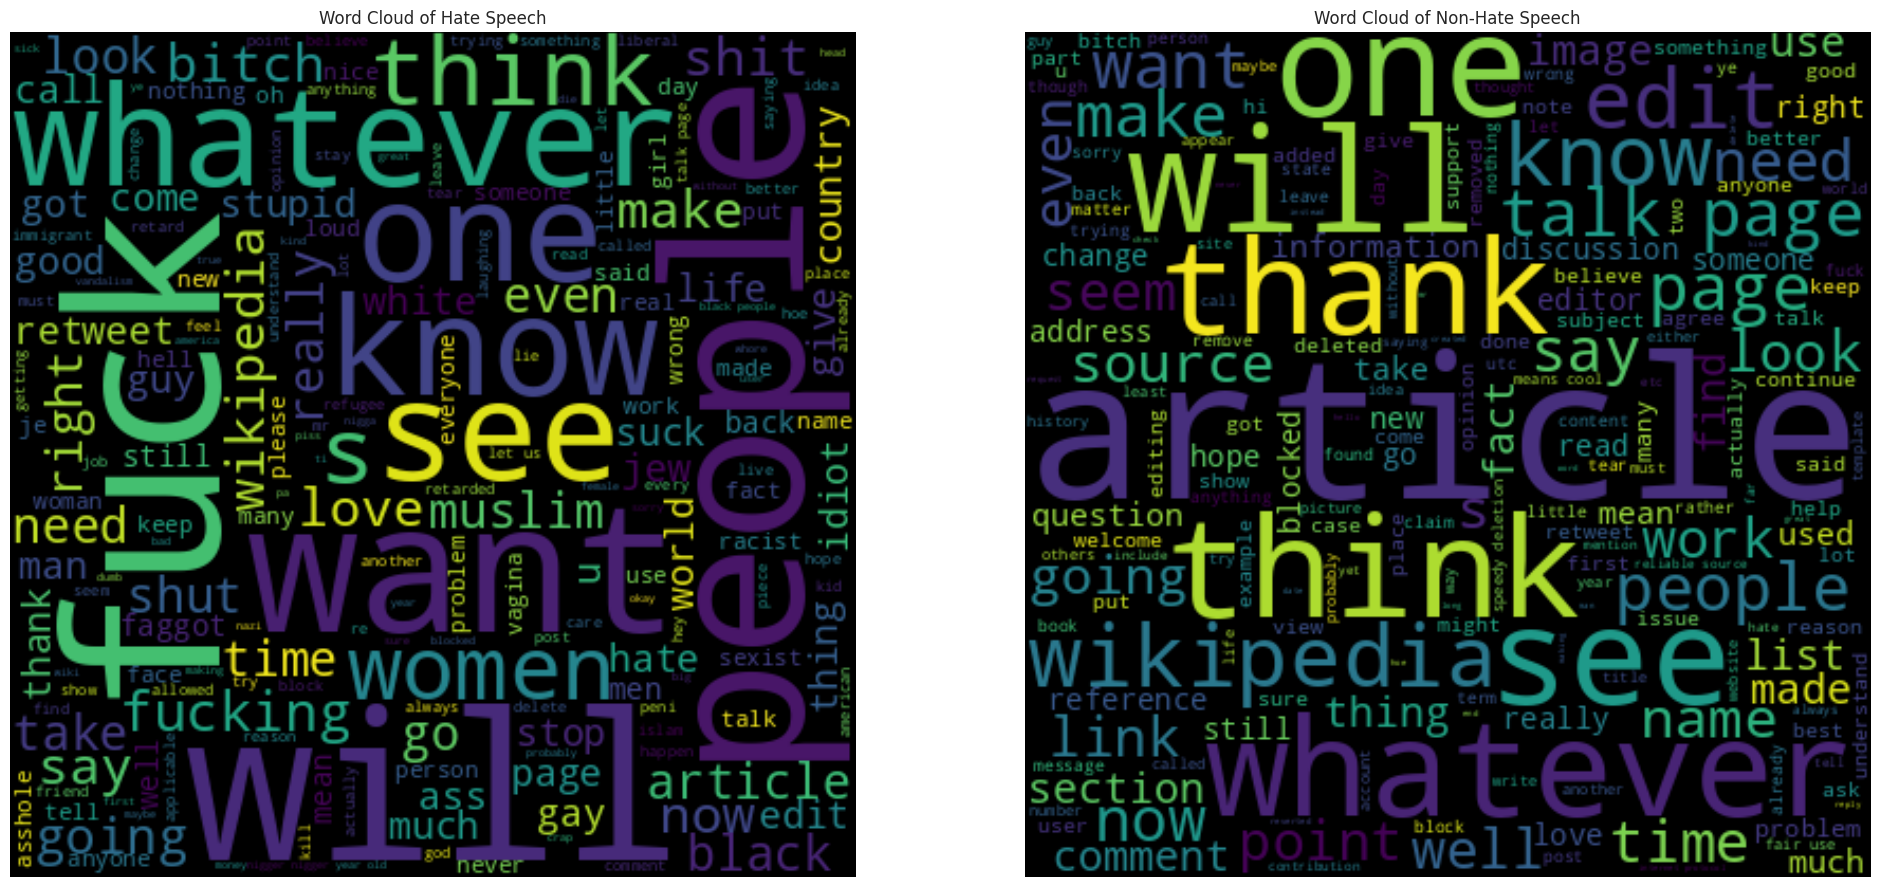

In [ ]:
hs_words = ' '.join([word for word in tweet_df['Content'][tweet_df['Label']=='1']])
nonhs_words = ' '.join([word for word in tweet_df['Content'][tweet_df['Label']=='0']])

hate_speech_wordcloud = WordCloud(width=400, height=400, max_font_size=100).generate(hs_words)
non_hate_speech_wordcloud = WordCloud(width=400, height=400, max_font_size=100).generate(nonhs_words)

plt.figure(figsize=(24, 20))

plt.subplot(1, 2, 1)
plt.imshow(hate_speech_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hate Speech')

plt.subplot(1, 2, 2)
plt.imshow(non_hate_speech_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Non-Hate Speech')

plt.show()

## Number of Rows

In [ ]:
print("Jumlah baris:", tweet_df.shape[0])
print("Jenis Label:", tweet_df['Label'].unique())

Jumlah baris: 384098
Jenis Label: ['1' '0' 'Label']


## Dataset Info and Describe

In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384098 entries, 0 to 384097
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Content      384098 non-null  object
 1   Label        384098 non-null  object
 2   Content_int  384098 non-null  object
dtypes: object(3)
memory usage: 8.8+ MB


In [ ]:
tweet_df.describe()

,Content,Label,Content_int
count,384098,384098,384098
unique,364412,3,364412
top,content,0,"[146715, 7139, 146714]"
freq,7,309759,7


> Melihat tabel diatas, bisa diambil bahwa terdapat content yang duplikat sekitar 20 ribu baris, dan label yang kelebihan

## Distribution of Data

Label
0        309759
1         74332
Label         7
Name: count, dtype: int64




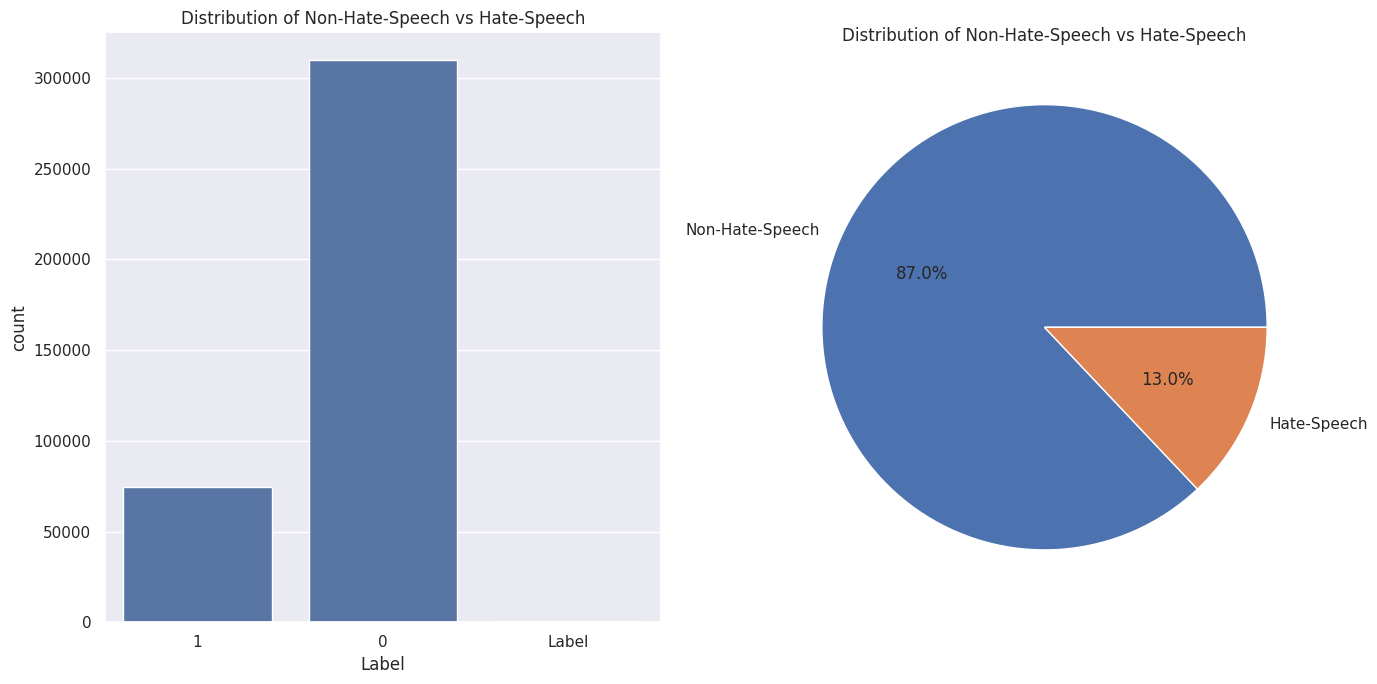

In [ ]:
print(tweet_df['Label'].value_counts())
print('\n')

jum_Non_HS = tweet_df[tweet_df['Label']=='0']['Label'].count()
jum_HS = tweet_df[tweet_df['Label']=='1']['Label'].count()
percent_Non_HS = (jum_Non_HS/(jum_Non_HS+jum_HS)*100)
percent_HS= (jum_HS/(jum_Non_HS+jum_Non_HS))*100

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

sns.countplot(x='Label', data=tweet_df, ax=axs[0])
axs[0].set_title('Distribution of Non-Hate-Speech vs Hate-Speech')


labels = ['Non-Hate-Speech', 'Hate-Speech']
sizes = [percent_Non_HS, percent_HS]
axs[1].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[1].set_title('Distribution of Non-Hate-Speech vs Hate-Speech')

plt.tight_layout()
plt.show()

> Jika diperhatikan pada label 'Label', terdapat 7 content yang diberikan label ini sehingga harus dihapus dari dataset

## Check Duplicate and Conflict Data

In [ ]:
print("Jumlah baris duplikat:", tweet_df.duplicated().sum())

Jumlah baris duplikat: 18835


In [ ]:
grouped = tweet_df.groupby('Content')['Label'].nunique()
conflicted_contents = grouped[grouped > 1]

print("Contoh yang konflik:", conflicted_contents)
print("Total 'Content' dengan label yang berbeda:", conflicted_contents.count())

Contoh yang konflik: Content
a kitten for you because heavy is clearly a pussy that just tries to because trouble                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                2
a mes

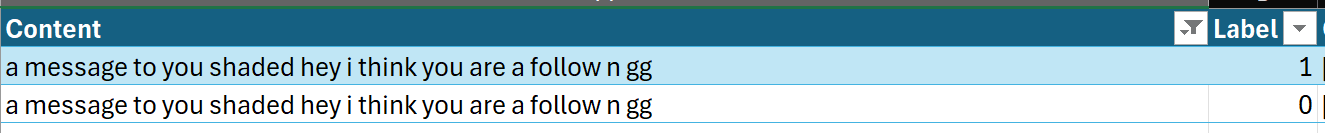

# Universal Preprocessing

## Remove "Content_int" Column

In [ ]:
tweet_df = tweet_df.drop(columns=['Content_int'])
tweet_df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


## Remove Labels Other Than 1 or 0

Jumlah baris 384091
Jenis Label: ['1' '0']
Axes(0.125,0.11;0.775x0.77)




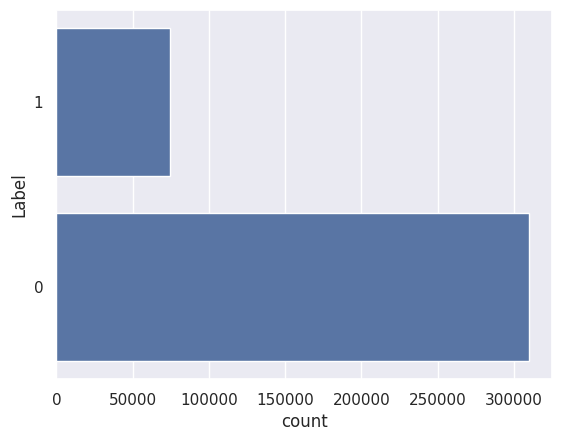

In [ ]:
tweet_df = tweet_df[tweet_df['Label'] != 'Label']
print("Jumlah baris", tweet_df.shape[0])
print("Jenis Label:", tweet_df['Label'].unique())
print(sns.countplot(tweet_df['Label']))
print('\n')

## Drop Duplicate Row

In [ ]:
tweet_df = tweet_df.drop_duplicates()
print("Jumlah baris duplikat:", tweet_df.duplicated().sum())

Jumlah baris duplikat: 0


## Drop Conflict Row


In [ ]:
conflicted_content_list = conflicted_contents.index.tolist()
tweet_df = tweet_df[~tweet_df['Content'].isin(conflicted_content_list)]

grouped = tweet_df.groupby('Content')['Label'].nunique()
conflicted_contents = grouped[grouped > 1]
print("Total 'Content' dengan label yang berbeda:", conflicted_contents.count())

Total 'Content' dengan label yang berbeda: 0


## Handle Imbalance Class

In [ ]:
print("Distribusi label sebelum undersampling:")
print(tweet_df['Label'].value_counts())

rus = RandomUnderSampler(random_state=42)
content_resampled, labels_resampled = rus.fit_resample(tweet_df[['Content']], tweet_df['Label'])

print("\nDistribusi label setelah undersampling:")
print(pd.Series(labels_resampled).value_counts())

tweet_df_resampled = pd.DataFrame({'Content': content_resampled.squeeze(), 'Label': labels_resampled})

Distribusi label sebelum undersampling:
Label
0    292633
1     70927
Name: count, dtype: int64

Distribusi label setelah undersampling:
Label
0    70927
1    70927
Name: count, dtype: int64


## Fix Slang Word

In [ ]:
def load_abbreviations(file_path):
    with open(file_path, 'r') as file:
        abbreviations = json.load(file)
    return abbreviations

abbreviations = load_abbreviations(ABBREVIATIONS_PATH)

def fix_slang(text):
    if isinstance(text, str):
        words = text.split()
        fixed_words = [abbreviations[word.lower()] if word.lower() in abbreviations else word for word in words]
        return ' '.join(fixed_words)
    return text

tweet_df_resampled['Fix_Slang'] = tweet_df_resampled['Content'].apply(fix_slang)
tweet_df_resampled.head()

,Content,Label,Fix_Slang
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...


## Fix Typo

In [ ]:
spell = SpellChecker()

def correct_typos(text):
    corrected_text = []
    for word in text.split():
        corrected_word = spell.correction(word)
        corrected_text.append(corrected_word)
    return ' '.join(corrected_text)

tweet_df_resampled['Fix_Typo'] = tweet_df_resampled['Fix_Slang'].apply(fix_slang)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...


## Clean Text

In [ ]:
def clean_text(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('\n', '', text)
    text = re.sub('RT', '', text)
    text = re.sub("[^a-zA-Z^']", " ", text)
    text = re.sub(" {2,}", " ", text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

def case_folding(data):
    temp_tweet = []
    for tw in data:
        tw = clean_text(tw)
        temp_tweet.append(tw)
    return temp_tweet

tweet_df_resampled['Case_folded']=case_folding(tweet_df_resampled['Fix_Typo'])
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...


## Tokenize

In [ ]:
def tokenize_text(text):
    return word_tokenize(text)

tweet_df_resampled['Tokenized'] = tweet_df_resampled['Fix_Typo'].apply(tokenize_text)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ..."
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am..."
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ..."
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table..."
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i..."


## Stemming

In [ ]:
stemming = SnowballStemmer('english')

def stem_tokens(token_list):
    return [stemming.stem(token) for token in token_list]

tweet_df_resampled['Stemmed'] = tweet_df_resampled['Tokenized'].apply(stem_tokens)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized,Stemmed
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ...","[you, current, appear, to, be, engag, in, an, ..."
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am...","[i, do, not, know, whi, you, peopl, think, ame..."
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ...","[full, protect, of, articl, excess, i, have, b..."
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table...","[i, ad, row, to, the, popular, vote, tabl, to,..."
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i...","[arbor, notif, as, you, particip, in, the, eye..."


## Lemmatizing

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(token_list):
    return [lemmatizer.lemmatize(token) for token in token_list]

tweet_df_resampled['Lemma'] = tweet_df_resampled['Stemmed'].apply(stem_tokens)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized,Stemmed,Lemma
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ...","[you, current, appear, to, be, engag, in, an, ...","[you, current, appear, to, be, engag, in, an, ..."
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am...","[i, do, not, know, whi, you, peopl, think, ame...","[i, do, not, know, whi, you, peopl, think, ame..."
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ...","[full, protect, of, articl, excess, i, have, b...","[full, protect, of, articl, excess, i, have, b..."
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table...","[i, ad, row, to, the, popular, vote, tabl, to,...","[i, ad, row, to, the, popular, vote, tabl, to,..."
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i...","[arbor, notif, as, you, particip, in, the, eye...","[arbor, notif, as, you, particip, in, the, eye..."


## Remove Stopwords

In [ ]:
eng_stopwords = stopwords.words('english')

def remove_stopwords(token_list):
    return [word for word in token_list if word not in eng_stopwords]

tweet_df_resampled['No_StopWord'] = tweet_df_resampled['Lemma'].apply(remove_stopwords)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized,Stemmed,Lemma,No_StopWord
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ...","[you, current, appear, to, be, engag, in, an, ...","[you, current, appear, to, be, engag, in, an, ...","[current, appear, engag, edit, war, accord, re..."
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am...","[i, do, not, know, whi, you, peopl, think, ame...","[i, do, not, know, whi, you, peopl, think, ame...","[know, whi, peopl, think, america, chang, beca..."
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ...","[full, protect, of, articl, excess, i, have, b...","[full, protect, of, articl, excess, i, have, b...","[full, protect, articl, excess, wikipedia, two..."
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table...","[i, ad, row, to, the, popular, vote, tabl, to,...","[i, ad, row, to, the, popular, vote, tabl, to,...","[ad, row, popular, vote, tabl, reflect, estim,..."
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i...","[arbor, notif, as, you, particip, in, the, eye...","[arbor, notif, as, you, particip, in, the, eye...","[arbor, notif, particip, eye, thread, led, req..."


## Combine To One String

In [ ]:
tweet_df_resampled['Clean'] = tweet_df_resampled['No_StopWord'].apply(lambda x: ' '.join(x))
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized,Stemmed,Lemma,No_StopWord,Clean
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ...","[you, current, appear, to, be, engag, in, an, ...","[you, current, appear, to, be, engag, in, an, ...","[current, appear, engag, edit, war, accord, re...",current appear engag edit war accord revert ma...
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am...","[i, do, not, know, whi, you, peopl, think, ame...","[i, do, not, know, whi, you, peopl, think, ame...","[know, whi, peopl, think, america, chang, beca...",know whi peopl think america chang becaus alwa...
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ...","[full, protect, of, articl, excess, i, have, b...","[full, protect, of, articl, excess, i, have, b...","[full, protect, articl, excess, wikipedia, two...",full protect articl excess wikipedia two year ...
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table...","[i, ad, row, to, the, popular, vote, tabl, to,...","[i, ad, row, to, the, popular, vote, tabl, to,...","[ad, row, popular, vote, tabl, reflect, estim,...",ad row popular vote tabl reflect estim michiga...
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i...","[arbor, notif, as, you, particip, in, the, eye...","[arbor, notif, as, you, particip, in, the, eye...","[arbor, notif, particip, eye, thread, led, req...",arbor notif particip eye thread led request se...


## Combining Cleaned Text and Labels to New DF

In [ ]:
dataset = tweet_df_resampled[['Clean', 'Label']].copy()
dataset['Label'] = pd.to_numeric(dataset['Label'])
dataset.head()

,Clean,Label
0,current appear engag edit war accord revert ma...,0
1,know whi peopl think america chang becaus alwa...,0
2,full protect articl excess wikipedia two year ...,0
3,ad row popular vote tabl reflect estim michiga...,0
4,arbor notif particip eye thread led request se...,0


# Feature Extraction and Modeling

## Machine Learning

### Feature Extraction

#### Feature Extraction (TF-IDF)

In [ ]:
X = dataset['Clean']
labels = dataset['Label']

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vector = tfidf_vectorizer.fit_transform(X)

#### Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vector, labels, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(113483, 1000)
(28371, 1000)
(113483,)
(28371,)


> Kami melakukan data splitting dengan 113483 training set, 28371 test set (80/20)

In [ ]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

max_tf_idfs = X_train.max(0).toarray()[0]
sorted_tf_idxs = max_tf_idfs.argsort()
sorted_tf_idfs = max_tf_idfs[sorted_tf_idxs]

smallest_tf_idfs = pd.Series(sorted_tf_idfs[:10], index=feature_names[sorted_tf_idxs[:10]])
largest_tf_idfs = pd.Series(sorted_tf_idfs[-10:][::-1], index=feature_names[sorted_tf_idxs[-10:][::-1]])

print('Most common words:\n', smallest_tf_idfs)
print('\n')
print('Most important words:\n', largest_tf_idfs)

Most common words:
 tild        0.564716
awar        0.681767
third       0.684557
provid      0.699849
signif      0.704662
coordin     0.719776
appropri    0.724355
entir       0.734164
pillar      0.735132
speedi      0.744417
dtype: float64


Most important words:
 abov     1.0
zero     1.0
za       1.0
young    1.0
yet      1.0
yes      1.0
year     1.0
anoth    1.0
annoy    1.0
anim     1.0
dtype: float64


> Most common word yang dihasilkan TF-IDF adalah kata - kata yang paling sering muncul <br>
dan most important word adalah kata - kata yang paling berdampak (semakin mendekati ke 1 semakin kata tersebut berdampak)<br><br>
TF-IDF ini kami gunakan untuk membantu model untuk menganalis kata - kata yang paling berpengaruh untuk deteksi ujaran kebencian

### Modeling

In [ ]:
def print_conf(y_test, result, classes, title='Confusion matrix'):
  conf_matrix = metrics.confusion_matrix(y_test, result)
  plt.figure(figsize=(6,6))
  sns.heatmap(conf_matrix,
              annot=True,
              xticklabels=classes,
              yticklabels=classes,
              cmap="Blues",
              fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(title)
  plt.show()

#### SVM

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

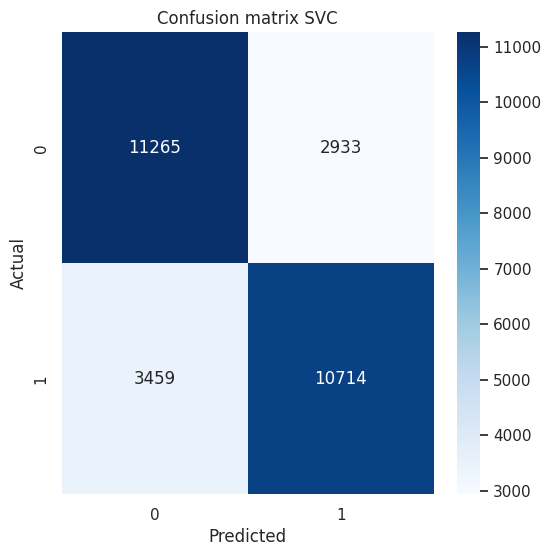

In [ ]:
print_conf(y_test, y_pred_svc, [0, 1], title="Confusion matrix SVC")

In [ ]:
print(metrics.classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     14198
           1       0.79      0.76      0.77     14173

    accuracy                           0.77     28371
   macro avg       0.78      0.77      0.77     28371
weighted avg       0.78      0.77      0.77     28371



#### Naive Bayes

In [ ]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

gnb = GaussianNB()
gnb.fit(X_train_dense, y_train)
y_pred_gnb = gnb.predict(X_test_dense)

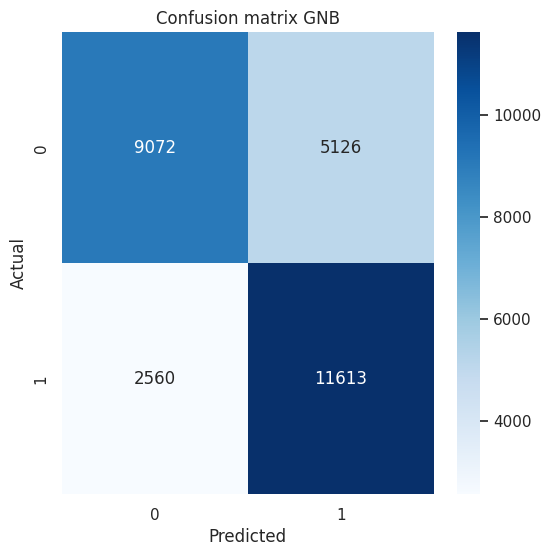

In [ ]:
print_conf(y_test, y_pred_gnb, [0, 1], title="Confusion matrix GNB")

In [ ]:
print(metrics.classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70     14198
           1       0.69      0.82      0.75     14173

    accuracy                           0.73     28371
   macro avg       0.74      0.73      0.73     28371
weighted avg       0.74      0.73      0.73     28371



In [ ]:
accSVM = metrics.accuracy_score(y_test,y_pred_svc)
accGNB = metrics.accuracy_score(y_test, y_pred_gnb)

## Deep Learning

### Feature Extraction

In [ ]:
vocab_size = 500
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(dataset['Clean'])

sequences = tokenizer.texts_to_sequences(dataset['Clean'])

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#### Split Data

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(padded_sequences, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_val.shape)

(85112, 50)
(28371, 50)
(28371, 50)
(85112,)
(28371,)
(28371,)


> Dapat dilihat total data untuk training ada 85112, validation 28371, testing 28371 (60/20/20)

### Modeling

#### LSTM

> Untuk model LSTM, activation function yang digunakan antar hidden layer adalah relu<br> tetapi outputnya menggunakan activation function 'sigmoid' (output sekitar 0 hingga 1) dikarenakan klasifikasi data yang berupa biner sehingga dapat menghitung loss dengan 'binary_crossentropy' dan metrics 'accuracy'

In [ ]:
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 64)            32000     
                                                                 
 lstm_17 (LSTM)              (None, 50, 64)            33024     
                                                                 
 dropout_10 (Dropout)        (None, 50, 64)            0         
                                                                 
 lstm_18 (LSTM)              (None, 32)                12416     
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 78529 (306.75 KB)
Trainable params: 785

Kita melakukan training dengan batch_size = 128, dan epoch sebanyak 30

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=128)

Epoch 1/30
665/665 [==============================] - 21s 24ms/step - loss: 0.5351 - accuracy: 0.7218 - val_loss: 0.5172 - val_accuracy: 0.7458
Epoch 2/30
665/665 [==============================] - 7s 11ms/step - loss: 0.5014 - accuracy: 0.7451 - val_loss: 0.4959 - val_accuracy: 0.7516
Epoch 3/30
665/665 [==============================] - 8s 13ms/step - loss: 0.4917 - accuracy: 0.7529 - val_loss: 0.4898 - val_accuracy: 0.7608
Epoch 4/30
665/665 [==============================] - 7s 11ms/step - loss: 0.4852 - accuracy: 0.7551 - val_loss: 0.4832 - val_accuracy: 0.7584
Epoch 5/30
665/665 [==============================] - 8s 12ms/step - loss: 0.4798 - accuracy: 0.7611 - val_loss: 0.4819 - val_accuracy: 0.7602
Epoch 6/30
665/665 [==============================] - 7s 11ms/step - loss: 0.4747 - accuracy: 0.7631 - val_loss: 0.4826 - val_accuracy: 0.7625
Epoch 7/30
665/665 [==============================] - 8s 12ms/step - loss: 0.4701 - accuracy: 0.7654 - val_loss: 0.4818 - val_accuracy: 0.755

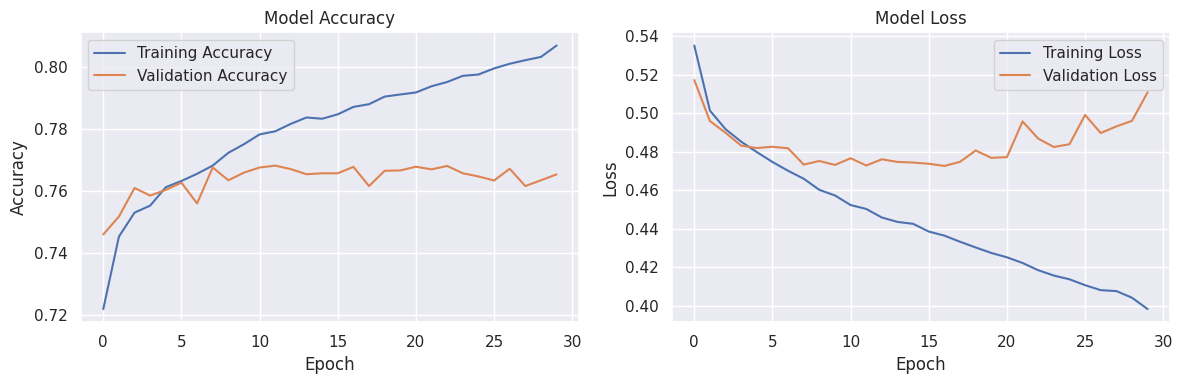

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

> Hasil plotting dari accuracy dan loss model per epoch

In [ ]:
y_pred_lstm_probs = lstm_model.predict(X_test)
y_pred_lstm = [1 if prob > 0.5 else 0 for prob in y_pred_lstm_probs]

887/887 [==============================] - 5s 5ms/step


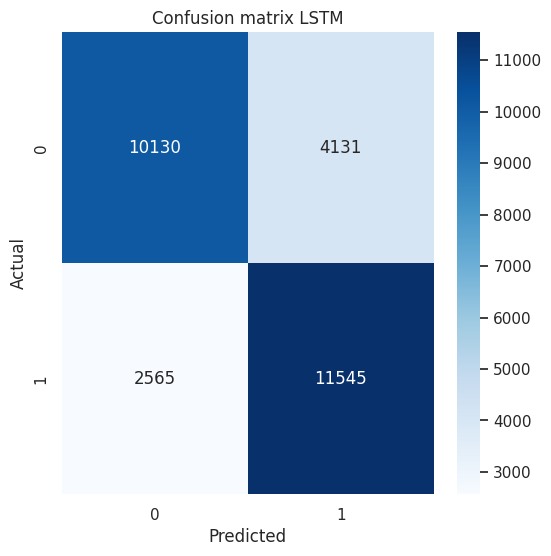

In [ ]:
print_conf(y_test, y_pred_lstm, [0, 1], title="Confusion matrix LSTM")

In [ ]:
print(metrics.classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75     14261
           1       0.74      0.82      0.78     14110

    accuracy                           0.76     28371
   macro avg       0.77      0.76      0.76     28371
weighted avg       0.77      0.76      0.76     28371



#Model Comparison

In [ ]:
models = ['SVM', 'NaiveBayes', 'LSTM']
accLSTM = metrics.accuracy_score(y_test, y_pred_lstm)
accuracies = [accSVM, accGNB, accLSTM]
comp = pd.DataFrame(list(zip(models, accuracies)), columns=['Model', 'Accuracy'])
comp

,Model,Accuracy
0,SVM,0.774700
1,NaiveBayes,0.729090
2,LSTM,0.763984


> Sebenarnya tidak adil untuk melakukan perbandingan model Machine Learning dengan Deep Learning, akan tetapi untuk dataset ini model SVM dapat berperforma lebih baik daripada LSTM

In [ ]:
best_model_name = comp.loc[comp['Accuracy'].idxmax()]['Model']
print(f"Best model is {best_model_name}")

if best_model_name == 'SVM':
    best_model = svc
    with open('TFIDFVectorizer.pkl', 'wb') as vectorizer_file:
        pickle.dump(tfidf_vectorizer, vectorizer_file)
elif best_model_name == 'NaiveBayes':
    best_model = gnb
    with open('TFIDFVectorizer.pkl', 'wb') as vectorizer_file:
        pickle.dump(tfidf_vectorizer, vectorizer_file)
elif best_model_name == 'LSTM':
    best_model = lstm_model

with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

Best model is SVM


#Predict New Data

> Uji coba hasil training model SVM

In [ ]:
input_tweet = [
    "Black people are losers",
    "You're a good person.",
    "I h8 u so much, you're a worthless piece of shit with a vagina!",
    "Great job on the project, keep it up!"
]

def preProcessText(input_tweet):
    new_tweets = []
    for tw in input_tweet:
        print(f"Input Text: {tw}")
        tw_slang = fix_slang(tw)
        print(f"Fix Slang: {tw_slang}")
        tw_typo = correct_typos(tw_slang)
        print(f"Correct Typo: {tw_typo}")
        tw_clean = clean_text(tw_typo)
        print(f"Clean Text: {tw_clean}")
        tw_tokenize = tokenize_text(tw_clean)
        print(f"Tokenize: {tw_tokenize}")
        tw_stem = stem_tokens(tw_tokenize)
        print(f"Stem Tokens: {tw_stem}")
        tw_lemma = lemmatize_tokens(tw_stem)
        print(f"Lemmatize Tokens: {tw_lemma}")
        tw_stopwords = remove_stopwords(tw_lemma)
        print(f"Remove Stopwords: {tw_stopwords}")
        tw_final = ' '.join(tw_stopwords)
        new_tweets.append(tw_final)
        print("\n")
    return new_tweets

def predictNewData(input_tweet):
    processed_tweets = preProcessText(input_tweet)

    with open('best_model.pkl', 'rb') as model_file:
        best_model = pickle.load(model_file)

    if best_model_name in ['SVM', 'NaiveBayes']:
        with open('TFIDFVectorizer.pkl', 'rb') as vectorizer_file:
            saved_tfidf = pickle.load(vectorizer_file)
        vectorized_tweets = saved_tfidf.transform(processed_tweets)
        input_prediction = best_model.predict(vectorized_tweets)
    else:
        sequences = tokenizer.texts_to_sequences(processed_tweets)
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
        input_prediction = best_model.predict(padded_sequences)
        input_prediction = np.argmax(input_prediction, axis=1)

    for i in range(len(input_tweet)):
        print(f"\nInput Text: {input_tweet[i]}")
        print(f"Processed Text: {processed_tweets[i]}")
        if input_prediction[i] == 1:
            print("Prediction: Hate Speech!\n")
        else:
            print("Prediction: Not a Hate Speech.\n")

predictNewData(input_tweet)


Input Text: Black people are losers
Fix Slang: Black people are losers
Correct Typo: Black people are losers
Clean Text: black people are losers
Tokenize: ['black', 'people', 'are', 'losers']
Stem Tokens: ['black', 'peopl', 'are', 'loser']
Lemmatize Tokens: ['black', 'peopl', 'are', 'loser']
Remove Stopwords: ['black', 'peopl', 'loser']


Input Text: You're a good person.
Fix Slang: you are a good person.
Correct Typo: you are a good person
Clean Text: you are a good person
Tokenize: ['you', 'are', 'a', 'good', 'person']
Stem Tokens: ['you', 'are', 'a', 'good', 'person']
Lemmatize Tokens: ['you', 'are', 'a', 'good', 'person']
Remove Stopwords: ['good', 'person']


Input Text: I h8 u so much, you're a worthless piece of shit with a vagina!
Fix Slang: I hate you so much, you are a worthless piece of shit with a vagina!
Correct Typo: I hate you so much you are a worthless piece of shit with a vagina
Clean Text: i hate you so much you are a worthless piece of shit with a vagina
Tokenize: [